### Целевая функция

Будем оптимизировать функцию лог-регрессии
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \text{log}(1 + \text{exp}(-y_i (Ax)_i))
$$
, где $x \in \mathbb{R}^d$, $L= \text{max}_i \| A_i \|^2$, $L_0 = 0$, $L_1 = \text{max}_i \| A_i \|$ $(\| A_i \| >> 1)$

### Данные 
Это продолжение эксперимента ex_L0_L1_and_FW_ill_cond_data.ipynb, но на этот раз данные "хорошие" и не сильно скоррелированны будут. За корреляцию отвечает параметр `rho` в функции `hard_FW_log_reg_jax.`
1) Случайные данные на l2 шаре при увеличении размерности. Данные НЕ скореллированные, зашумленность невысокая
2) Случайные данные на симплексе при увеличении размерности. Данные НЕ скореллированные, зашумленность невысокая
3) Случайные данные на l-\infty шаре при увеличении размерности. Данные НЕ скореллированные, зашумленность невысокая
4) Данные на датасете L0L1_FW_log_reg_a9a

### Алгоритмы
В экспериментах сравниваются следующие методы:
- Алгоритм Франк-Вульфа с шагом основанным на L0,L1 гладкости (FW-L0_L1_shortest)
- Алгоритм Франк-Вульфа с шагом основанным на L0,L1 гладкости с логарифмическим шагом (FW-L0_L1_log_and_linear)
- Алгоритм Франк-Вульфа с шагом основанным на L0,L1 гладкости с логарифмическим шагом (FW-L0_L1_log_and_linear), где на каждой итерации $L_1$ шаг проверяется на то, чтобы шаг всегда был логарифмическим (FW-L0_L1_log_only)
- Алгоритм Франк-Вульфа классический (FW-classic) с shortest step

### Цель эксперимента

Прошлый эксперимент показал ex_L0_L1_and_FW_ill_cond_data, что на политопах и при высоких размерностях есть преимущества у новых алгоритмов, цель проверить будет ли это преимущество более явным на "хороших" данных. Так же проверить на реальном датасете, будет ли $(L_0, L_1)$ shortest step тут лучше? 

Что проверим?

1) Проверка на симплексе при увеличении размерности. Перезапустить 5-7 раз
2) Проверка на симплексе x0 скраю. При увеличении размерности. Перезапустить 5-7 раз
3) Проверка на l_2 шаре при увеличении размерности. Перезапустить 5-7 раз
4) Проверка на l_\infty шаре при увеличении размерности. Перезапустить 5-7 раз

In [2]:
import sys
import os

# Get the parent directory of the notebook (2 levels up)
notebook_dir = os.path.abspath(os.path.join(os.getcwd(), "../../"))
if notebook_dir not in sys.path:
    sys.path.append(notebook_dir)

In [3]:
import numpy as np
import jax
import matplotlib.pyplot as plt

import accbpg

random_seed = 456

## $L_2$-шар, увеличение числа векторов

Running for n_samples=200, n_features=200

FW L0,L1 smooth logarithmic algorithm
     k      F(x)         L         L0         L1     log step count       time
     0    6.931e-01    1.080e+01    4.545e-13    1.077e+01        1         0.1

FW L0,L1 smooth algorithm with fixed L1
     k      F(x)         L         L0         L1     log step count       time
     0    6.931e-01    1.080e+01    4.545e-13    1.077e+01        1         0.0

FW adaptive algorithm
     k      F(x)         Lk       time
     0   6.931e-01   2.554e+02     0.0

FW L0,L1 smooth algorithm
     k      F(x)         L           L0              L1     step-size     time
     0    6.931e-01    1.080e+01     4.545e-13       1.077e+01        2.731e-03        0.0
Running for n_samples=2000, n_features=200

FW L0,L1 smooth logarithmic algorithm
     k      F(x)         L         L0         L1     log step count       time
     0    6.931e-01    7.755e+00    4.545e-13    1.145e+01        1         0.2
   100    1.852e-02  

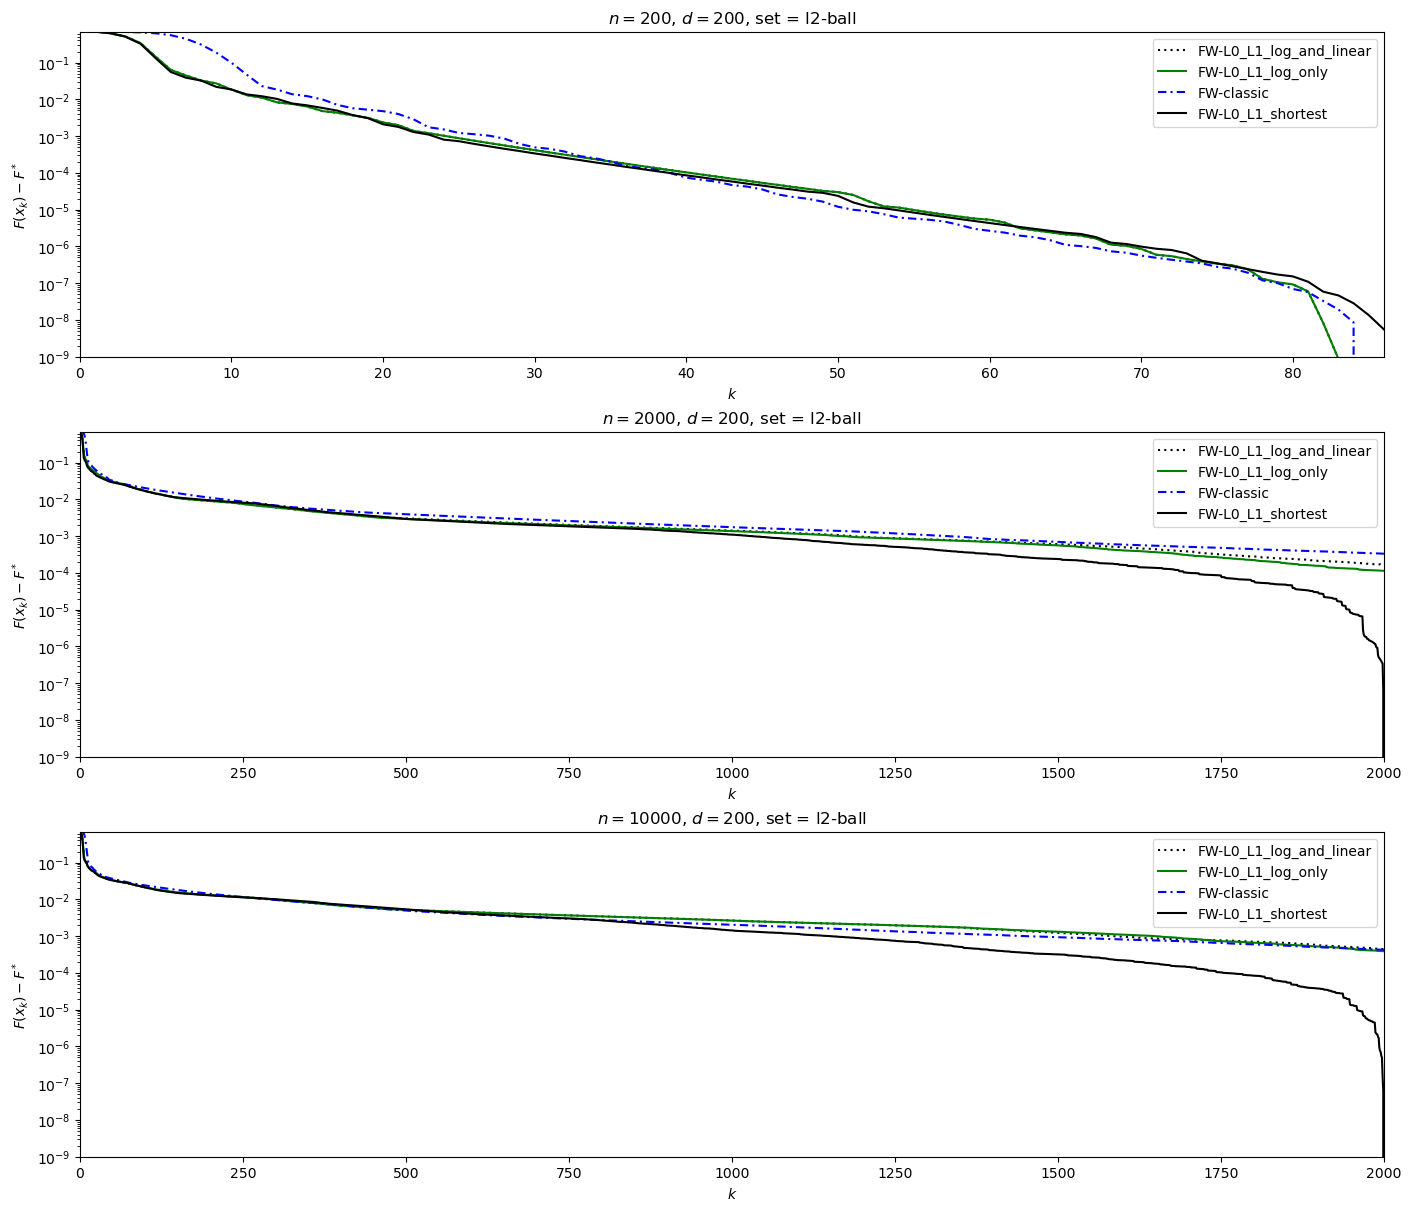

In [4]:
fig, axes = plt.subplots(
    3, 1,
    figsize=(14, 12),
    sharex=False,
    sharey=False,
    constrained_layout=True
)


eps = 1e-8
max_iters = 2000
verbskip = int(max_iters / 20)
ls_ratio = 2.2

key = jax.random.key(random_seed)

l1_max_factor = 5
ball_constrnt_radius = 25


labels = [r"FW-L0_L1_log_and_linear", r"FW-L0_L1_log_only", r"FW-classic", r"FW-L0_L1_shortest"]

# configs = [
#     (200, 2000),
#     (2000, 200),
#     (1000, 1000),
# ]

configs = [
    (200, 200),
    (2000, 200),
    (10000, 200),
]

for i, (n_samples, n_features) in enumerate(configs):
    print(f"Running for n_samples={n_samples}, n_features={n_features}")
    f, h, L, L0, L1, x0, X_data, y_true = accbpg.hard_FW_log_reg_jax(key, 
                                                     n_samples, n_features, 
                                                     radius=ball_constrnt_radius, 
                                                     domain="l2",
                                                     rho=0.02,
                                                     col_scale=2,
                                                     flip_y=0.0,
                                                     noise=0.01)
    lmo = accbpg.lmo_l2_ball(ball_constrnt_radius)
    lmo_name = "l2-ball"

    _, F_l0l1_log_and_linear, _, _, _ = accbpg.FW_l0l1_log_and_linear_step(
        f, h, L0, L1, x0, max_iters, lmo, ls_ratio=ls_ratio, 
        epsilon=eps, linesearch=True, verbskip=verbskip
    )

    _, F_l0l1_log_only, _, _, _ = accbpg.FW_l0l1_log_only(
        f, h, L0, L1, x0, maxitrs=max_iters, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip
    )

    _, F_classic, _, _ = accbpg.FW_alg_div_step(
        f, h, L, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip
    )

    _, F_l0l1_shortest_step, _, _ = accbpg.FW_alg_L0_L1_shortest_step(
        f, h, L0, L1, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip
    )

    y_min = min(np.min(F_l0l1_log_and_linear), np.min(F_classic), np.min(F_l0l1_shortest_step), np.min(F_l0l1_log_only))
    y_max = max(np.max(F_l0l1_log_and_linear), np.max(F_classic), np.max(F_l0l1_shortest_step), np.max(F_l0l1_log_only))

    max_executed_iters = max(len(F_l0l1_log_and_linear), len(F_classic), len(F_l0l1_shortest_step), len(F_l0l1_log_only))

    ax = axes[i]
    accbpg.plot_comparisons(
        ax,
        [F_l0l1_log_and_linear, F_l0l1_log_only, F_classic, F_l0l1_shortest_step],
        labels,
        xlim=[0, max_executed_iters],
        ylim=[1e-9, y_max],  # Adjusted for log scale
        x_vals=[], plotdiff=True, yscale="log",
        xlabel=r"$k$",
        ylabel=r"$F(x_k) - F^*$",
        legendloc="upper right"
    )

    ax.set_title(f"$n = {n_samples}$, $d = {n_features}$, set = {lmo_name}")

# Optional: save the figure
# plt.savefig("FW_comparison_grid.pdf", bbox_inches='tight')
plt.show()

## $L_2$-шар, увеличение размерности

Running for n_samples=200, n_features=200

FW L0,L1 smooth logarithmic algorithm
     k      F(x)         L         L0         L1     log step count       time
     0    6.931e-01    1.080e+01    4.545e-13    1.077e+01        1         0.1

FW L0,L1 smooth algorithm with fixed L1
     k      F(x)         L         L0         L1     log step count       time
     0    6.931e-01    1.080e+01    4.545e-13    1.077e+01        1         0.0

FW adaptive algorithm
     k      F(x)         Lk       time
     0   6.931e-01   2.554e+02     0.0

FW L0,L1 smooth algorithm
     k      F(x)         L           L0              L1     step-size     time
     0    6.931e-01    1.080e+01     4.545e-13       1.077e+01        2.731e-03        0.0
Running for n_samples=200, n_features=2000

FW L0,L1 smooth logarithmic algorithm
     k      F(x)         L         L0         L1     log step count       time
     0    6.931e-01    7.584e+01    4.545e-13    3.131e+01        1         0.2

FW L0,L1 smooth algo

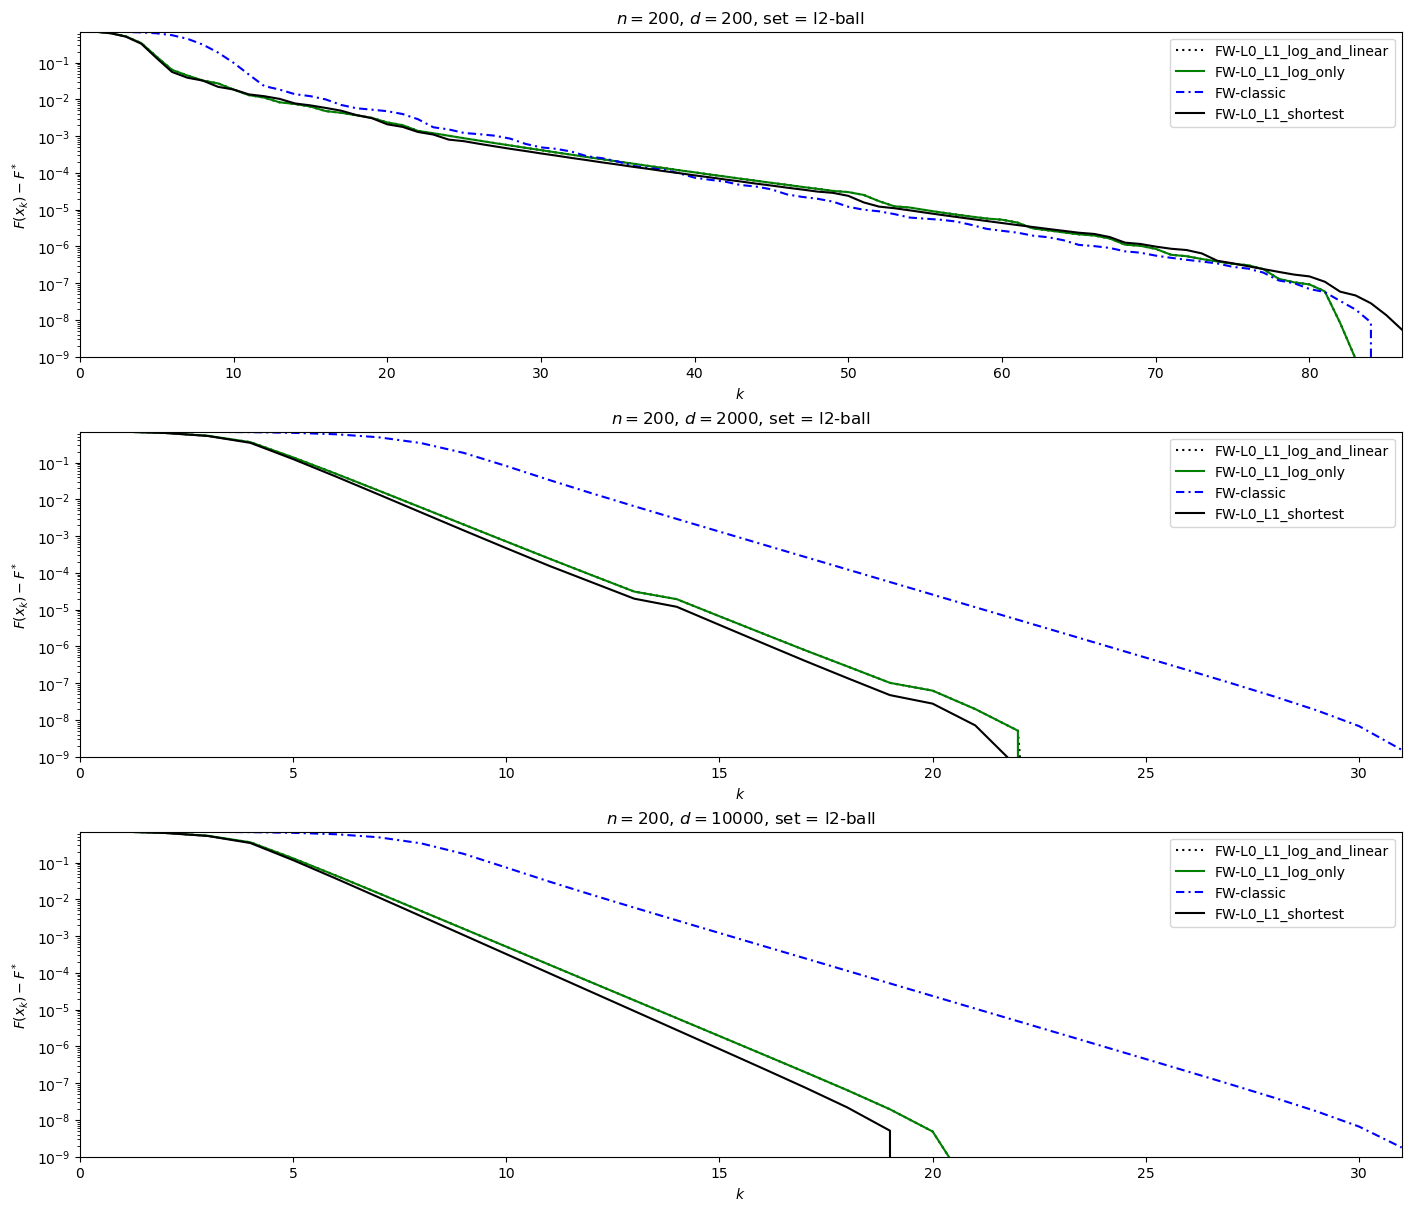

In [5]:
fig, axes = plt.subplots(
    3, 1,
    figsize=(14, 12),
    sharex=False,
    sharey=False,
    constrained_layout=True
)


eps = 1e-8
max_iters = 2000
verbskip = int(max_iters / 20)
ls_ratio = 2.2

key = jax.random.key(random_seed)

l1_max_factor = 5
ball_constrnt_radius = 25


labels = [r"FW-L0_L1_log_and_linear", r"FW-L0_L1_log_only", r"FW-classic", r"FW-L0_L1_shortest"]

# configs = [
#     (200, 2000),
#     (2000, 200),
#     (1000, 1000),
# ]

configs = [
    (200, 200),
    (200, 2000),
    (200, 10000),
]

for i, (n_samples, n_features) in enumerate(configs):
    print(f"Running for n_samples={n_samples}, n_features={n_features}")
    f, h, L, L0, L1, x0, X_data, y_true = accbpg.hard_FW_log_reg_jax(key, 
                                                     n_samples, n_features, 
                                                     radius=ball_constrnt_radius, 
                                                     domain="l2",
                                                     rho=0.02,
                                                     col_scale=2,
                                                     flip_y=0.0,
                                                     noise=0.01)
    lmo = accbpg.lmo_l2_ball(ball_constrnt_radius)
    lmo_name = "l2-ball"

    _, F_l0l1_log_and_linear, _, _, _ = accbpg.FW_l0l1_log_and_linear_step(
        f, h, L0, L1, x0, max_iters, lmo, ls_ratio=ls_ratio, 
        epsilon=eps, linesearch=True, verbskip=verbskip
    )

    _, F_l0l1_log_only, _, _, _ = accbpg.FW_l0l1_log_only(
        f, h, L0, L1, x0, maxitrs=max_iters, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip
    )

    _, F_classic, _, _ = accbpg.FW_alg_div_step(
        f, h, L, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip
    )

    _, F_l0l1_shortest_step, _, _ = accbpg.FW_alg_L0_L1_shortest_step(
        f, h, L0, L1, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip
    )

    y_min = min(np.min(F_l0l1_log_and_linear), np.min(F_classic), np.min(F_l0l1_shortest_step), np.min(F_l0l1_log_only))
    y_max = max(np.max(F_l0l1_log_and_linear), np.max(F_classic), np.max(F_l0l1_shortest_step), np.max(F_l0l1_log_only))

    max_executed_iters = max(len(F_l0l1_log_and_linear), len(F_classic), len(F_l0l1_shortest_step), len(F_l0l1_log_only))

    ax = axes[i]
    accbpg.plot_comparisons(
        ax,
        [F_l0l1_log_and_linear, F_l0l1_log_only, F_classic, F_l0l1_shortest_step],
        labels,
        xlim=[0, max_executed_iters],
        ylim=[1e-9, y_max],  # Adjusted for log scale
        x_vals=[], plotdiff=True, yscale="log",
        xlabel=r"$k$",
        ylabel=r"$F(x_k) - F^*$",
        legendloc="upper right"
    )

    ax.set_title(f"$n = {n_samples}$, $d = {n_features}$, set = {lmo_name}")

# Optional: save the figure
# plt.savefig("FW_comparison_grid.pdf", bbox_inches='tight')
plt.show()

## $L_2$-шар, зависимость $(L_0,L_1)$ алгоритмов от числа векторов.

Running for n_samples=200, n_features=200

FW L0,L1 smooth logarithmic algorithm
     k      F(x)         L         L0         L1     log step count       time
     0    6.931e-01    1.080e+01    4.545e-13    1.077e+01        1         0.1
     1    6.316e-01    4.459e+00    2.066e-13    4.898e+00        2         0.1
     2    5.163e-01    1.618e+00    9.391e-14    2.226e+00        3         0.1
     3    3.391e-01    4.519e-01    4.269e-14    1.012e+00        4         0.1
     4    1.442e-01    1.842e-01    4.269e-14    1.012e+00        5         0.1
     5    6.354e-02    1.964e-01    9.391e-14    2.226e+00        6         0.1
     6    4.458e-02    1.415e-01    9.391e-14    2.226e+00        7         0.1
     7    3.253e-02    2.499e-01    2.066e-13    4.898e+00        8         0.1
     8    2.714e-02    7.792e-02    9.391e-14    2.226e+00        9         0.1
     9    1.845e-02    5.483e-02    9.391e-14    2.226e+00       10         0.1
    10    1.304e-02    1.031e-01    2.06

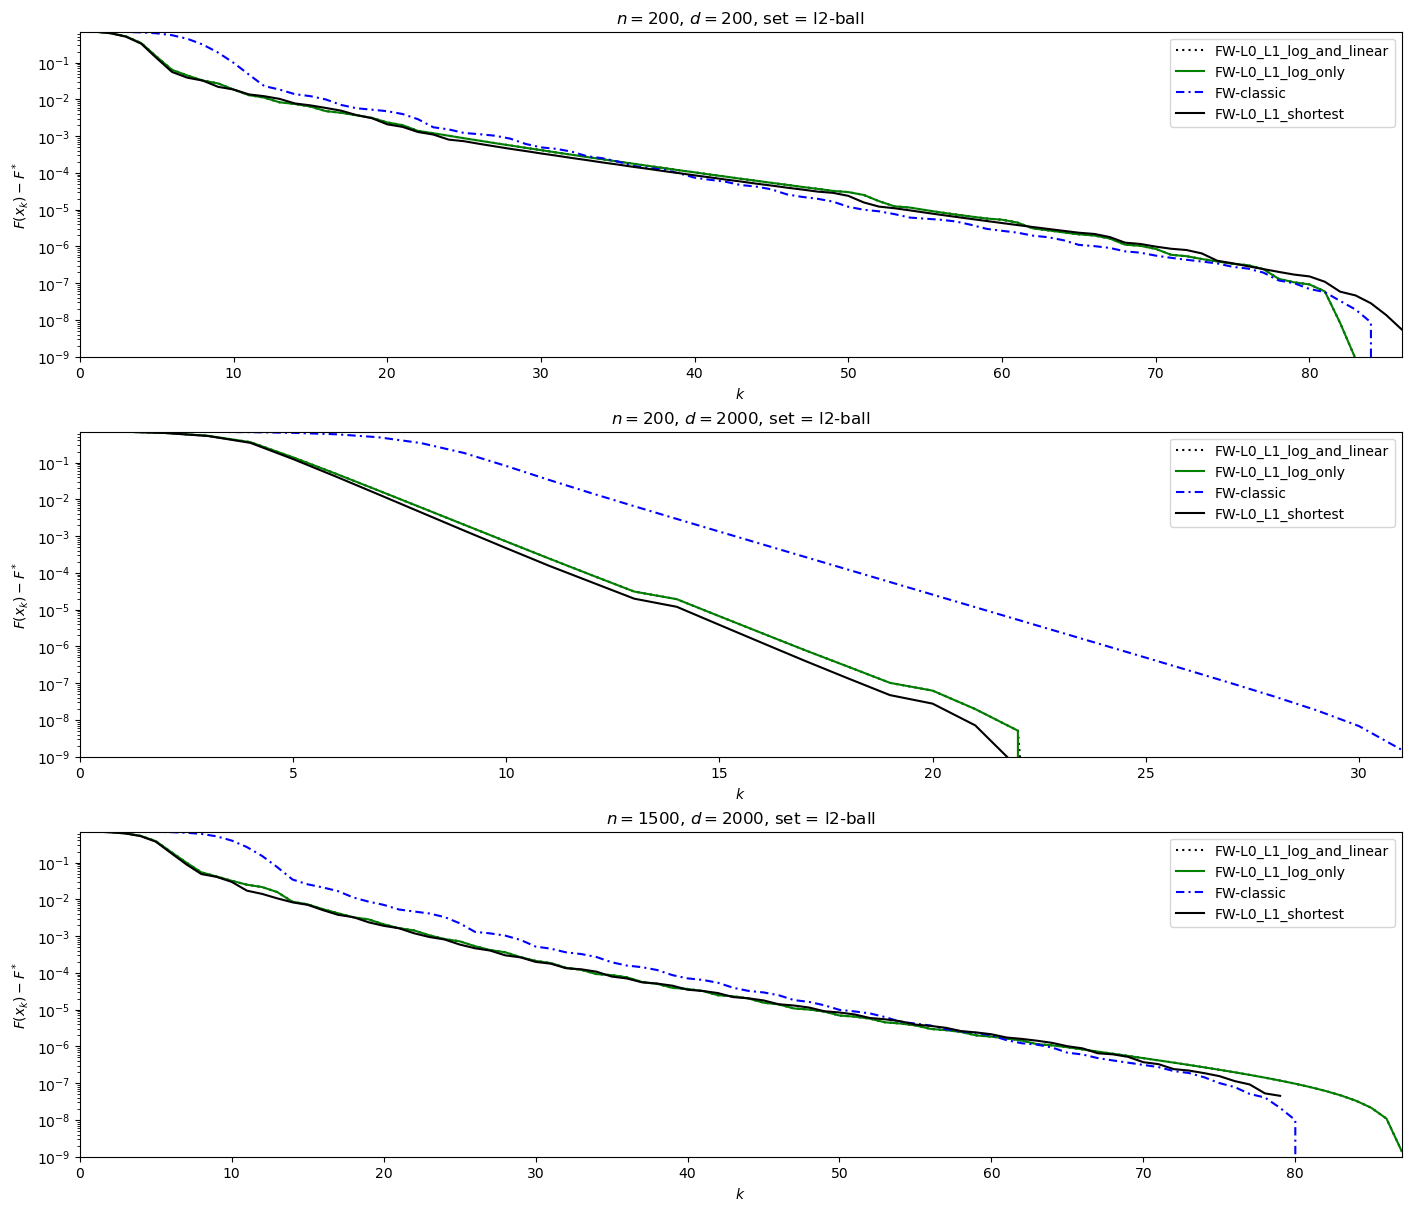

: 

In [ ]:
fig, axes = plt.subplots(
    3, 1,
    figsize=(14, 12),
    sharex=False,
    sharey=False,
    constrained_layout=True
)


eps = 1e-8
max_iters = 2000
verbskip = 1
ls_ratio = 2.2

key = jax.random.key(random_seed)

l1_max_factor = 5
ball_constrnt_radius = 25


labels = [r"FW-L0_L1_log_and_linear", r"FW-L0_L1_log_only", r"FW-classic", r"FW-L0_L1_shortest"]

configs = [
    (200, 200),
    (200, 2000),
    (1500, 2000),
]

for i, (n_samples, n_features) in enumerate(configs):
    print(f"Running for n_samples={n_samples}, n_features={n_features}")
    f, h, L, L0, L1, x0, X_data, y_true = accbpg.hard_FW_log_reg_jax(key, 
                                                     n_samples, n_features, 
                                                     radius=ball_constrnt_radius, 
                                                     domain="l2",
                                                     rho=0.02,
                                                     col_scale=2.0,
                                                     flip_y=0.0,
                                                     noise=0.01)
    lmo = accbpg.lmo_l2_ball(ball_constrnt_radius)
    lmo_name = "l2-ball"

    _, F_l0l1_log_and_linear, _, _, _ = accbpg.FW_l0l1_log_and_linear_step(
        f, h, L0, L1, x0, max_iters, lmo, ls_ratio=ls_ratio, 
        epsilon=eps, linesearch=True, verbskip=verbskip
    )

    _, F_l0l1_log_only, _, _, _ = accbpg.FW_l0l1_log_only(
        f, h, L0, L1, x0, maxitrs=max_iters, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip
    )

    _, F_classic, _, _ = accbpg.FW_alg_div_step(
        f, h, L, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip
    )

    _, F_l0l1_shortest_step, _, _ = accbpg.FW_alg_L0_L1_shortest_step(
        f, h, L0, L1, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip
    )

    y_min = min(np.min(F_l0l1_log_and_linear), np.min(F_classic), np.min(F_l0l1_shortest_step), np.min(F_l0l1_log_only))
    y_max = max(np.max(F_l0l1_log_and_linear), np.max(F_classic), np.max(F_l0l1_shortest_step), np.max(F_l0l1_log_only))

    max_executed_iters = max(len(F_l0l1_log_and_linear), len(F_classic), len(F_l0l1_shortest_step), len(F_l0l1_log_only))

    ax = axes[i]
    accbpg.plot_comparisons(
        ax,
        [F_l0l1_log_and_linear, F_l0l1_log_only, F_classic, F_l0l1_shortest_step],
        labels,
        xlim=[0, max_executed_iters],
        ylim=[1e-9, y_max],  # Adjusted for log scale
        x_vals=[], plotdiff=True, yscale="log",
        xlabel=r"$k$",
        ylabel=r"$F(x_k) - F^*$",
        legendloc="upper right"
    )

    ax.set_title(f"$n = {n_samples}$, $d = {n_features}$, set = {lmo_name}")

# Optional: save the figure
# plt.savefig("FW_comparison_grid.pdf", bbox_inches='tight')
plt.show()

## Симплекс, увеличение размерности

Running for n_samples=200, n_features=2000

FW L0,L1 smooth logarithmic algorithm
     k      F(x)         L         L0         L1     log step count       time
     0    6.931e-01    7.346e+01    4.545e-13    3.131e+01        1         0.1
   200    4.452e-01    1.042e+00    8.820e-15    6.075e-01        5         1.0
   400    4.427e-01    4.720e-01    4.009e-15    2.762e-01        5         1.9
   600    4.419e-01    1.037e+00    8.820e-15    6.075e-01        5         2.7
   800    4.414e-01    1.036e+00    8.820e-15    6.075e-01        5         3.6
  1000    4.412e-01    1.036e+00    8.820e-15    6.075e-01        5         4.4
  1200    4.410e-01    1.035e+00    8.820e-15    6.075e-01        5         5.3
  1400    4.409e-01    1.035e+00    8.820e-15    6.075e-01        5         6.3
  1600    4.408e-01    1.035e+00    8.820e-15    6.075e-01        5         7.2
  1800    4.407e-01    4.704e-01    4.009e-15    2.762e-01        5         8.0

FW L0,L1 smooth algorithm with fixed L

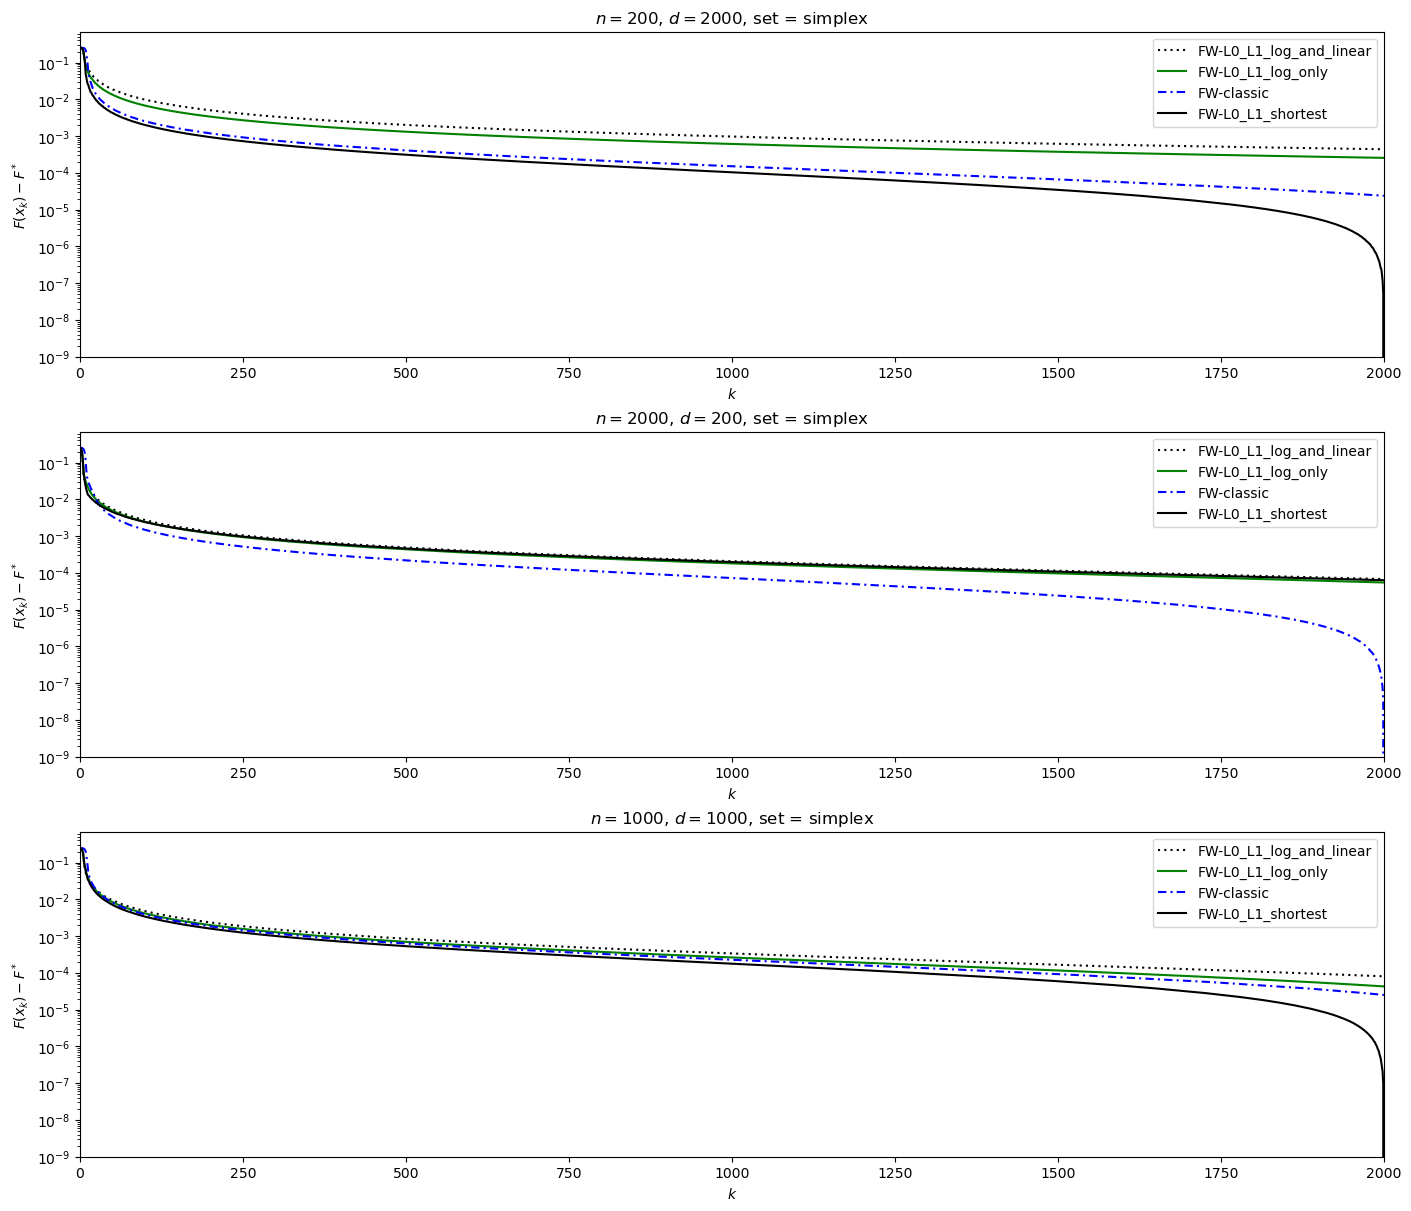

In [ ]:
fig, axes = plt.subplots(
    3, 1,
    figsize=(14, 12),  # увеличенная ширина и особенно высота
    sharex=False,   # keep only shared x-axis
    sharey=False,  # allow separate y-limits
    constrained_layout=True
)


eps = 1e-8
max_iters = 2000
verbskip = max_iters / 10
ls_ratio = 2.2

key = jax.random.key(random_seed)

l1_max_factor = 5
ball_constrnt_radius = 1

labels = [r"FW-L0_L1_log_and_linear", r"FW-L0_L1_log_only", r"FW-classic", r"FW-L0_L1_shortest"]

configs = [
    (200, 2000),
    (2000, 200),
    (1000, 1000),
]

for i, (n_samples, n_features) in enumerate(configs):
    print(f"Running for n_samples={n_samples}, n_features={n_features}")
    f, h, L, L0, L1, x0, X_data, y_true = accbpg.hard_FW_log_reg_jax(key, 
                                                     n_samples, n_features, 
                                                     radius=ball_constrnt_radius, 
                                                     domain="simplex",
                                                     k_sparse=5,
                                                     rho=0.02,
                                                     col_scale=2,
                                                     flip_y=0.0,
                                                     noise=0.01)
    lmo = accbpg.lmo_simplex(ball_constrnt_radius)
    lmo_name = "simplex"

    _, F_l0l1_log_and_linear, _, _, _ = accbpg.FW_l0l1_log_and_linear_step(
            f, h, L0, L1, x0, max_iters, lmo, ls_ratio=ls_ratio, 
            L1_max=L1*ls_ratio, L0_max=L0*ls_ratio, epsilon=eps, 
            linesearch=True, verbskip=verbskip
    )
    
    _, F_l0l1_log_only, _, _, _ = accbpg.FW_l0l1_log_only(
        f, h, L0, L1, x0, maxitrs=max_iters, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, L1_max=L1*ls_ratio, L0_max=L0*ls_ratio, linesearch=True, 
        verbskip=verbskip
    )

    _, F_classic, _, _ = accbpg.FW_alg_div_step(
        f, h, L, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip
    )

    _, F_l0l1_shortest_step, _, _ = accbpg.FW_alg_L0_L1_shortest_step(
        f, h, L0, L1, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip
    )

    ax = axes[i]
    y_min = min(np.min(F_l0l1_log_and_linear), np.min(F_classic), np.min(F_l0l1_shortest_step), np.min(F_l0l1_log_only))
    y_max = max(np.max(F_l0l1_log_and_linear), np.max(F_classic), np.max(F_l0l1_shortest_step), np.max(F_l0l1_log_only))

    max_executed_iters = max(len(F_l0l1_log_and_linear), len(F_classic), len(F_l0l1_shortest_step), len(F_l0l1_log_only))

    accbpg.plot_comparisons(
        ax,
        [F_l0l1_log_and_linear, F_l0l1_log_only, F_classic, F_l0l1_shortest_step],
        labels,
        xlim=[0, max_executed_iters],
        ylim=[1e-9, y_max], plotdiff=True, yscale="log",
        xlabel=r"$k$",
        ylabel=r"$F(x_k) - F^*$",
        legendloc="upper right"
    )

    ax.set_title(f"$n = {n_samples}$, $d = {n_features}$, set = {lmo_name}")

# Optional: save the figure
# plt.savefig("FW_comparison_grid.pdf", bbox_inches='tight')
plt.show()

## $L_{\infty}$ шар

Running for n_samples=200, n_features=2000

FW L0,L1 smooth logarithmic algorithm
     k      F(x)         L         L0         L1     log step count       time
     0    6.931e-01    3.520e+01    4.545e-13    2.113e+01        1         0.1

FW L0,L1 smooth algorithm with fixed L1
     k      F(x)         L         L0         L1     log step count       time
     0    6.931e-01    3.520e+01    4.545e-13    2.113e+01        1         0.0

FW adaptive algorithm
     k      F(x)         Lk       time
     0   6.931e-01   9.822e+02     0.0

FW L0,L1 smooth algorithm
     k      F(x)         L           L0              L1     step-size     time
     0    6.931e-01    3.520e+01     4.545e-13       2.113e+01        2.506e-05        0.0
Running for n_samples=2000, n_features=200

FW L0,L1 smooth logarithmic algorithm
     k      F(x)         L         L0         L1     log step count       time
     0    6.931e-01    3.182e+00    4.545e-13    7.547e+00        1         0.1
   200    6.903e-03 

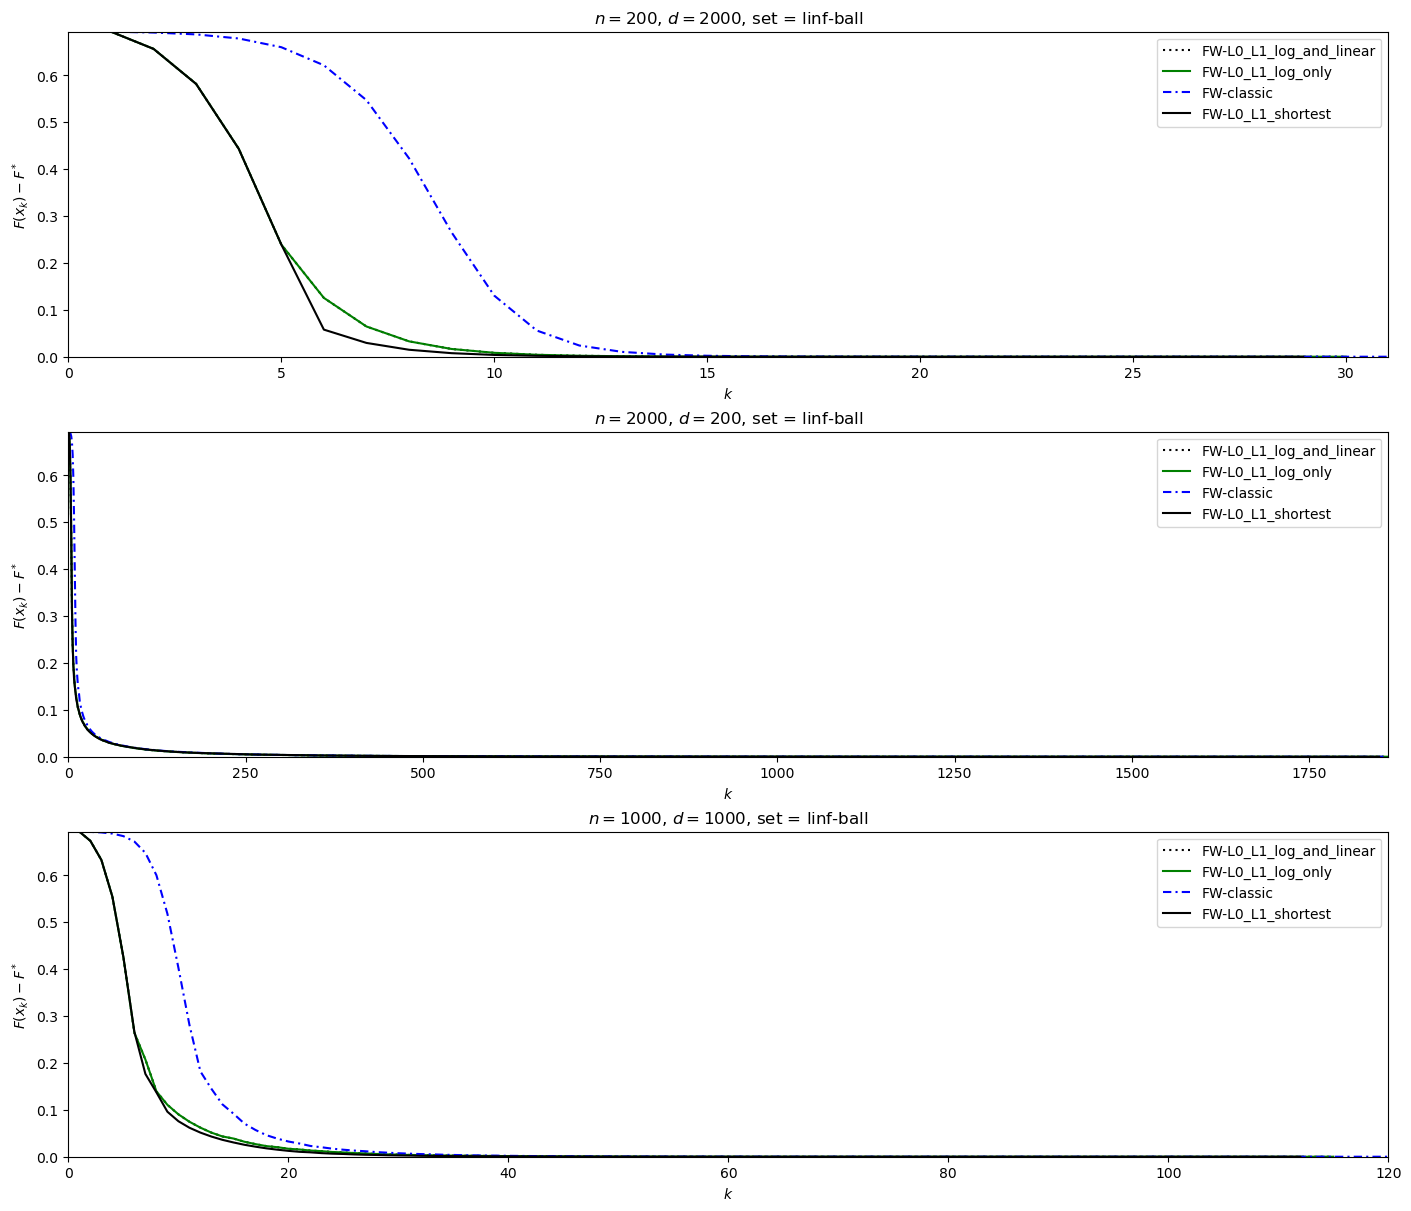

In [9]:
fig, axes = plt.subplots(
    3, 1,
    figsize=(14, 12),  # увеличенная ширина и особенно высота
    sharex=False,   # keep only shared x-axis
    sharey=False,  # allow separate y-limits
    constrained_layout=True
)


eps = 1e-8
max_iters = 2000
verbskip = max_iters / 10
ls_ratio = 2.2

key = jax.random.key(random_seed)

l1_max_factor = 5
ball_constrnt_radius = 25


labels = [r"FW-L0_L1_log_and_linear", r"FW-L0_L1_log_only", r"FW-classic", r"FW-L0_L1_shortest"]

configs = [
    (200, 2000),
    (2000, 200),
    (1000, 1000),
]

for i, (n_samples, n_features) in enumerate(configs):
    print(f"Running for n_samples={n_samples}, n_features={n_features}")
    f, h, L, L0, L1, x0, X_data, y_true = accbpg.hard_FW_log_reg_jax(key, 
                                                     n_samples, n_features, 
                                                     radius=ball_constrnt_radius, 
                                                     domain="linf",
                                                     rho=0.001,
                                                     col_scale=1.0,
                                                     flip_y=0.0,
                                                     noise=0.01)
    lmo = accbpg.lmo_linf_ball(ball_constrnt_radius)
    lmo_name = "linf-ball"

    x_l0l1_log, F_l0l1_log_and_linear, _, _, _ = accbpg.FW_l0l1_log_and_linear_step(
            f, h, L0, L1, x0, max_iters, lmo, ls_ratio=ls_ratio, 
            L1_max=None, epsilon=eps, linesearch=True, verbskip=verbskip
    )
    
    x_l0_l1_step_fixed_l1, F_l0l1_log_only, _, _, _ = accbpg.FW_l0l1_log_only(
        f, h, L0, L1, x0, maxitrs=max_iters, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip
    )

    x_standard, F_classic, _, _ = accbpg.FW_alg_div_step(
        f, h, L, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip
    )

    x_l0_l1_step, F_l0l1_shortest_step, _, _ = accbpg.FW_alg_L0_L1_shortest_step(
        f, h, L0, L1, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip
    )

    ax = axes[i]
    y_min = min(np.min(F_l0l1_log_and_linear), np.min(F_classic), np.min(F_l0l1_shortest_step), np.min(F_l0l1_log_only))
    y_max = max(np.max(F_l0l1_log_and_linear), np.max(F_classic), np.max(F_l0l1_shortest_step), np.max(F_l0l1_log_only))

    max_executed_iters = max(len(F_l0l1_log_and_linear), len(F_classic), len(F_l0l1_shortest_step), len(F_l0l1_log_only))

    accbpg.plot_comparisons(
        ax,
        [F_l0l1_log_and_linear, F_l0l1_log_only, F_classic, F_l0l1_shortest_step],
        labels,
        xlim=[0, max_executed_iters], ylim=[0, y_max], plotdiff=True, yscale="linear",
        xlabel=r"$k$",
        ylabel=r"$F(x_k) - F^*$",
        legendloc="upper right"
    )

    ax.set_title(f"$n = {n_samples}$, $d = {n_features}$, set = {lmo_name}")

# Optional: save the figure
# plt.savefig("FW_comparison_grid.pdf", bbox_inches='tight')
plt.show()

## Выводы

В ex_L0_L1_and_FW_ill_cond_data.ipynb была поставлена гипотеза, что новые версии алгоритма лучше работают на больших размерностях. Тут удалось увидеть, что это происходит скорее не из-за большой размерности, а при малом числе векторов в лог-регрессии. Пчму? Птмчто градиент при малом числе векторов меньше и соответственно параметр $a_k = L_0 + L_1 \| \nabla f(x_k )\|$ низкий в силу малости $\| \nabla f(x_k )\|$. Перезапускал около 10 раз с рызным seed и результаты получались примерно одинаковыми, а именно:
1) FW-L0_L1_shortest устойчиво лучше на любом допустимом множестве. 
2) Чем ниже у целевой функции градиент, тем быстрее работают $(L_0, L_1)$ алгоритмы. Это полностью удалось подтвердить в разделе ## $L_2$-шар, зависимость $(L_0,L_1)$ алгоритмов от числа векторов. Мы видим, что при увеличении числа векторов эти алгоритмы теряют свое превосходство над классической версией. Зато при мало числе векторов **на любых сколь угодно больших размерностях** эти алгоритмы показывают сильное превосходство над классической версией.
3) И на симплексе и на $L_{\infty}$-шаре история повторяется вновь. При большом числе векторов новые алгоритмы теряют свое превосходство
4) FW-L0_L1_shortest устойчиво и значимо лучше, чем FW-L0_L1_log_only, а FW-L0_L1_log_only лучше, чем FW-L0_L1_log_and_linear

И тут напрашивается интересный вывод. Тут, по сути, мы добились адаптивности, только на этот раз параметр $L$ у нас адаптируется автоматически в силу присутствия $\| \nabla f(x_k) \|$ в функции параметра. Такие явления вполне можно изучать дальше, какие еще функциональные зависимости мы можем "зашивать" в параметры?

Так же при высоком значении $\| \nabla f(x_k) \|$ параметр L1 можно уменьшать быстрее, но пока непонятно как это делать